In [1]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.means import ZeroMean, ConstantMean
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import random
import os
import numpy as np

# Seed Everything

In [2]:
class PGLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    # contribution to Eqn (10) in Reference [1].
    def expected_log_prob(self, target, input, *args, **kwargs):
        mean, variance = input.mean, input.variance
        # Compute the expectation E[f_i^2]
        raw_second_moment = variance + mean.pow(2)

        # Translate targets to be -1, 1
        target = target.to(mean.dtype).mul(2.).sub(1.)

        # We detach the following variable since we do not want
        # to differentiate through the closed-form PG update.
        c = raw_second_moment.detach().sqrt()
        # Compute mean of PG auxiliary variable omega: 0.5 * Expectation[omega]
        # See Eqn (11) and Appendix A2 and A3 in Reference [1] for details.
        half_omega = 0.25 * torch.tanh(0.5 * c) / c

        # Expected log likelihood
        res = 0.5 * target * mean - half_omega * raw_second_moment
        # Sum over data points in mini-batch
        res = res.sum(dim=-1)

        return res

    # define the likelihood
    def forward(self, function_samples):
        return torch.distributions.Bernoulli(logits=function_samples)

    # define the marginal likelihood using Gauss Hermite quadrature
    def marginal(self, function_dist):
        prob_lambda = lambda function_samples: self.forward(function_samples).probs
        probs = self.quadrature(prob_lambda, function_dist)
        return torch.distributions.Bernoulli(probs=probs)


class SingletaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel_type='rbf', nu=0.5):
        """
        Args:
            inducing_points (torch.Tensor):
            kernel_type (str):
            nu (float):
        """
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SingletaskGPModel, self).__init__(variational_strategy)

        # self.mean_module = gpytorch.means.ZeroMean()
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel_type == 'rbf':
            self.covar_module = ScaleKernel(RBFKernel())
        elif kernel_type == 'matern_kernel':
            self.covar_module = ScaleKernel(MaternKernel(nu=nu))
        else:
            raise ValueError("kernel_type must be either 'rbf' or 'matern_kernel'")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
threshold = 0.5

class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            # nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            # nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))

        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

# Model

In [4]:
# Define the CNN_Att Model
class CNN_Att(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, Xtrain, BagLabels, num_ind=50, verbose=False):
        super(CNN_Att, self).__init__()
        self.attention_layer = AttentionLayer(feature_dim, hidden_dim)
        self.fc = nn.Linear(feature_dim + 1, output_dim)  # Fully connected layer
        self.dropout = nn.Dropout(0.25)


        inducing_points = torch.rand(num_ind, 1) # Random
        self.gp_layer = SingletaskGPModel(inducing_points)
        with torch.inference_mode():
            self.gp_layer.covar_module.base_kernel.lengthscale = torch.tensor([2.0])
            self.gp_layer.covar_module.outputscale = torch.tensor([0.5])

        self.fc_gp = nn.Linear(feature_dim, 1)
        # self.fc_gp = nn.Sequential(
        #     nn.Linear(feature_dim, feature_dim),
        #     nn.Dropout(0.25),
        #     nn.PReLU(),
        #     nn.Linear(feature_dim, feature_dim),
        #     nn.Dropout(0.25),
        #     nn.PReLU(),
        #     nn.Linear(feature_dim, 1)
        # )
        # self.batch_norm = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attended_features, attention_weights = self.attention_layer(x)
        # attended_features = self.batch_norm(attended_features)
        # attended_features = self.dropout(attended_features)
        x = self.fc_gp(attended_features)
        gp_output = self.gp_layer(x)
        output = self.fc(torch.cat([attended_features, gp_output.mean.unsqueeze(-1)], dim=-1))

        return output, gp_output, _

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Load data from CSV
def load_data(csv_file, num_instances=57, test_size=0.2, random_state=42):
    df = pd.read_csv(csv_file)

    # Group features by bag_name
    grouped = df.groupby('bag_name')

    # Prepare feature lists and label lists
    feature_list = []
    label_list = []

    for bag_name, group in grouped:
        # Extract features for the current bag
        feature_cols = [f'feature_{i}' for i in range(8)]
        features = group[feature_cols].values

        # Pad with zeros if the number of instances is less than num_instances
        if len(features) < num_instances:
            padding_size = num_instances - len(features)
            padding = np.zeros((padding_size, 8))
            features = np.vstack((features, padding))  # Vertically stack features and padding

        # Truncate if the number of instances is greater than num_instances (shouldn't happen, but good to be safe)
        elif len(features) > num_instances:
            features = features[:num_instances]

        feature_list.append(features)

        # Get the bag label for the current bag
        bag_label = group['bag_label'].values[0]
        label_list.append(bag_label)

    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(label_list)

    return X, y

# Training function
def train(model, dataloader, optimizer, criterion, device, likelihood, var_optimizer, mlls):
    model.train()
    likelihood.train()
    epoch_loss = 0
    all_labels = []
    all_preds = []
    with gpytorch.settings.num_likelihood_samples(100):
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            var_optimizer.zero_grad()

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)
            predictions = predictions.squeeze(1)  # Remove the extra dimension to match labels' shape

            loss = -mlls(gp_output, labels) * 0.5 + criterion(predictions, labels) * 0.5
            # loss = -mlls(gp_output, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            var_optimizer.step()

            epoch_loss += loss.item()
            # preds = (torch.sigmoid(predictions) > 0.5).float()
            preds = likelihood(gp_output).probs.ge(threshold).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    average = 'weighted'
    precision = precision_score(all_labels, all_preds, average=average)
    recall = recall_score(all_labels, all_preds, average=average)
    f1 = f1_score(all_labels, all_preds, average=average)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1

# Evaluation function
def evaluate(model, dataloader, criterion, device, likelihood, mlls):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)
            predictions = predictions.squeeze(1)  # Remove the extra dimension to match labels' shape
            # loss = criterion(predictions, labels)
            # loss = -mlls(gp_output, labels) * 0.5 + criterion(predictions, labels) * 0.5
            loss = -mlls(gp_output, labels)

            epoch_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            # preds = (torch.sigmoid(predictions) > 0.5).float()
            probs = likelihood(gp_output).probs
            preds = (probs >= threshold).float()
            all_preds.extend((preds >= threshold).cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    average = 'binary'
    precision = precision_score(all_labels, all_preds, average=average)
    recall = recall_score(all_labels, all_preds, average=average)
    f1 = f1_score(all_labels, all_preds, average=average)
    cohen_kappa = cohen_kappa_score(all_labels, all_preds)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1, cohen_kappa, all_labels, all_preds
# Function to plot ROC AUC curve
def plot_roc_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def plot_pr_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_scores):
    y_pred = []
    for score in y_scores:
        if score >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

Positive weights: 0.05000000074505806
Starting training...
Epoch 1/200: Train: Loss=0.1963, Acc=0.6190, Precision=0.6789, Recall=0.6190, F1=0.5171 | Test: Loss=-0.0165, Acc=0.6267, Precision=1.0000, Recall=0.2222, F1=0.3636, Cohen Kappa=0.2291

Epoch 2/200: Train: Loss=0.1558, Acc=0.7560, Precision=0.8233, Recall=0.7560, F1=0.7263 | Test: Loss=-0.0676, Acc=0.7867, Precision=1.0000, Recall=0.5556, F1=0.7143, Cohen Kappa=0.5652

Epoch 3/200: Train: Loss=0.1156, Acc=0.8650, Precision=0.8847, Recall=0.8650, F1=0.8595 | Test: Loss=-0.1402, Acc=0.8733, Precision=1.0000, Recall=0.7361, F1=0.8480, Cohen Kappa=0.7437

Epoch 4/200: Train: Loss=0.0759, Acc=0.9010, Precision=0.9108, Recall=0.9010, F1=0.8986 | Test: Loss=-0.1856, Acc=0.8933, Precision=1.0000, Recall=0.7778, F1=0.8750, Cohen Kappa=0.7845

Epoch 5/200: Train: Loss=0.0498, Acc=0.9160, Precision=0.9202, Recall=0.9160, F1=0.9148 | Test: Loss=-0.2091, Acc=0.9067, Precision=0.9833, Recall=0.8194, F1=0.8939, Cohen Kappa=0.8118

Epoch 6/200

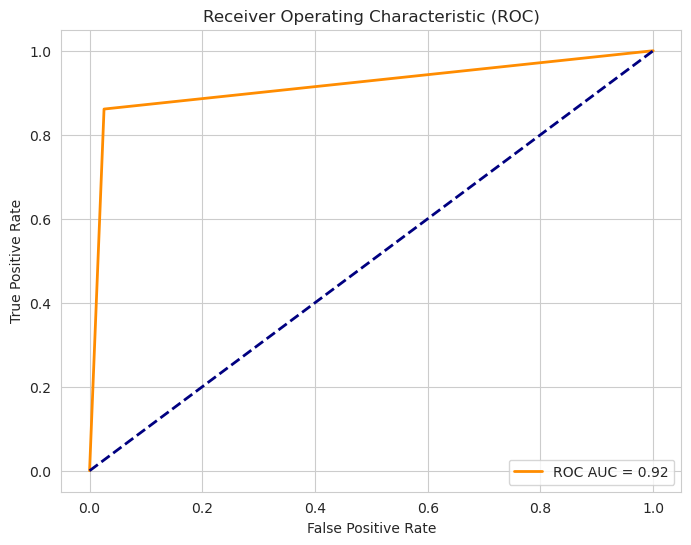

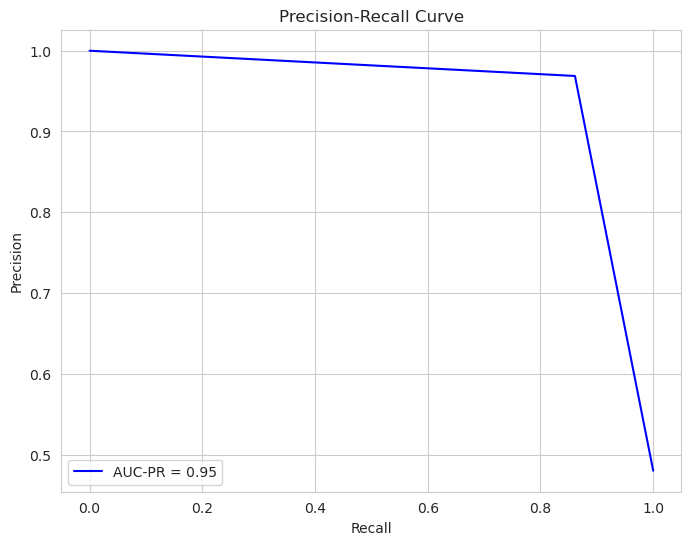

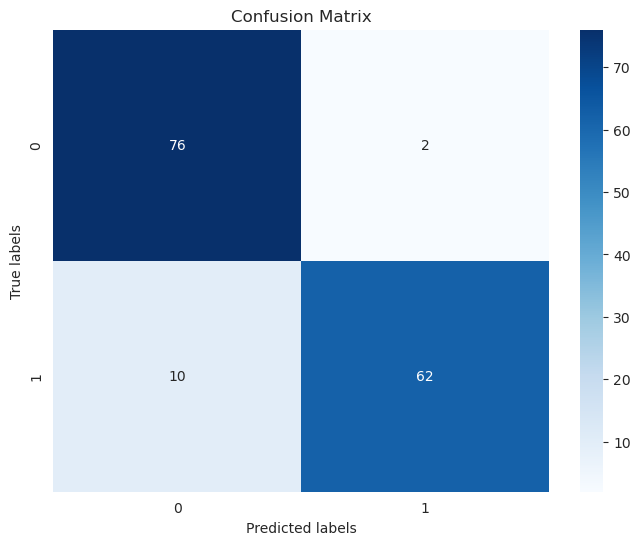

In [5]:
# Main function
def main(train_file, test_file, hidden_dim=128, learning_rate=0.0001, batch_size=16, num_epochs=200, num_instances=57):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    # X_train, y_train, X_test, y_test = load_data(csv_file, num_instances=num_instances)
    X_train, y_train = load_data(train_file, num_instances=num_instances)
    X_test, y_test = load_data(test_file, num_instances=num_instances)

    # Create Datasets and DataLoaders
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, optimizer, and loss function
    feature_dim = X_train.shape[2]  # which is 8
    output_dim = 1

    model = CNN_Att(feature_dim, hidden_dim, output_dim, X_train, y_train).to(device)
    likelihood = PGLikelihood().to(device)

    mlls = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader))
    variational_ngd_optim = gpytorch.optim.NGD(model.gp_layer.variational_parameters(), num_data=len(train_loader), lr=0.01)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # pos_weights = torch.tensor([np.sum(y_train == 0) / np.sum(y_train == 1)], dtype=torch.float32).to(device)
    pos_weights = torch.tensor([0.05], dtype=torch.float32).to(device)
    print(f'Positive weights: {pos_weights.item()}')
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Binary cross-entropy loss with logits

    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc,  train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device, likelihood, variational_ngd_optim, mlls)
        test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}'
                f' | Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}, Cohen Kappa={test_co_kappa:.4f}\n')

    # Plot ROC AUC curve
    test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls)
    plot_roc_auc(test_labels, test_scores)
    plot_pr_curve(test_labels, test_scores)
    plot_confusion_matrix(test_labels, test_scores)

if __name__ == "__main__":
    def seed_everything(seed=26):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


    seed_everything()
    # Example usage:
    train_file = 'author_data/rsna_train_2.csv'  # Replace with your CSV file path
    test_file = 'author_data/rsna_test_2.csv'
    main(train_file, test_file, num_instances=57)

# Visualization

In [6]:
import pandas as pd

def analyze_data(csv_file):
    """
    Loads the data from the specified CSV file, groups it by 'bag_name',
    and prints each group as a separate DataFrame.
    Args:
        csv_file (str): The path to the CSV file.
    Returns:
        pandas.core.groupby.generic.DataFrameGroupBy: A DataFrameGroupBy object
        grouped by 'bag_name'.  You can iterate through this object
        to access the DataFrames for each bag.
    """
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File not found at {csv_file}")
        return None  # Return None if the file is not found

    grouped_df = df.groupby('bag_name')

    return grouped_df

def main():
    csv_file = 'author_data/rsna_train_0.csv'  # Replace with your actual CSV file path
    grouped_df = analyze_data(csv_file)

    if grouped_df is not None:
        # Example of how to access the DataFrame for a specific bag_name:
        try:
            bag_name_id = 'ID_04ef429610'
            specific_bag = grouped_df.get_group(bag_name_id)  # Replace 'ID_0043db2b67' with a bag_name from your CSV
            print("\n--- Specific Bag Name: %s ---", bag_name_id)
            display(specific_bag)
        except KeyError:
            print("\nBag name 'ID_04ef429610' not found.") # Or whatever ID

if __name__ == "__main__":
    main()


--- Specific Bag Name: %s --- ID_04ef429610


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,cnn_prediction,instance_label,instance_name,bag_name,bag_label,bag_cnn_prediction,bag_cnn_probability
0,1.055466,0.857516,3.476764,2.330864,3.074527,-1.725298,2.926703,-2.084662,0,0,ID_0000f1657.dcm,ID_04ef429610,0,0,0.117545
347,1.395636,0.594634,3.897089,2.538553,3.871753,-2.192451,3.853203,-2.530340,0,0,ID_0285088a7.dcm,ID_04ef429610,0,0,0.117545
1756,0.409879,0.267687,1.299901,0.817363,1.383013,-0.650636,1.280363,-0.939533,0,0,ID_0cbbafebe.dcm,ID_04ef429610,0,0,0.117545
2439,1.805650,0.446514,4.910050,3.141197,4.999012,-3.054663,5.055044,-3.232859,0,0,ID_116b522a4.dcm,ID_04ef429610,0,0,0.117545
3616,1.485529,0.796208,5.142868,3.219294,4.725407,-2.289799,4.561205,-3.039275,0,0,ID_1a2afb4b3.dcm,ID_04ef429610,0,0,0.117545
5881,1.356669,0.735594,4.786742,2.945501,4.308814,-2.063673,4.188759,-2.822770,0,0,ID_2b3a4948c.dcm,ID_04ef429610,0,0,0.117545
7565,0.898298,0.805831,2.834731,1.804770,2.513618,-1.564803,2.348717,-1.786567,0,0,ID_382278bfd.dcm,ID_04ef429610,0,0,0.117545
9524,1.595791,0.624633,4.506394,2.890864,4.487806,-2.613356,4.436447,-2.900167,0,0,ID_46a867e42.dcm,ID_04ef429610,0,0,0.117545
9619,0.490395,0.422270,1.439179,1.102035,1.270430,-0.781379,1.287870,-1.034335,0,0,ID_474c2435d.dcm,ID_04ef429610,0,0,0.117545
9672,0.908218,0.719447,3.035627,2.108694,2.704356,-1.495891,2.629515,-1.887021,0,0,ID_47c7f01cb.dcm,ID_04ef429610,0,0,0.117545


In [7]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#
# # Define the Attention Layer
# class AttentionLayer(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(AttentionLayer, self).__init__()
#         self.attention = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Linear(hidden_dim, 1)
#         )
#
#     def forward(self, x):
#         # x shape: (batch_size, num_instances, feature_dim)
#         attention_weights = self.attention(x)
#         weights = F.softmax(attention_weights, dim=1)
#
#         return (x * weights).sum(dim=1), weights.squeeze(-1)
#
# # Define the CNN_Att Model
# class CNN_Att(nn.Module):
#     def __init__(self, feature_dim, hidden_dim, output_dim):
#         super(CNN_Att, self).__init__()
#         self.attention_layer = AttentionLayer(feature_dim, hidden_dim)
#         self.fc = nn.Linear(feature_dim, output_dim)  # Fully connected layer
#         self.dropout = nn.Dropout(0.25)
#
#     def forward(self, x):
#         # x shape: (batch_size, num_instances, feature_dim)
#         attended_features, attention_weights = self.attention_layer(x)
#         attended_features = self.dropout(attended_features)
#         output = self.fc(attended_features)  # Pass attended features to FC layer
#         return output, attention_weights
#
# # Define a custom Dataset
# class CustomDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = torch.tensor(features, dtype=torch.float32)
#         self.labels = torch.tensor(labels, dtype=torch.float32)
#
#     def __len__(self):
#         return len(self.labels)
#
#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]
#
# # Load data from CSV
# def load_data(csv_file, num_instances=57):
#     df = pd.read_csv(csv_file)
#
#     # Group features by bag_name
#     grouped = df.groupby('bag_name')
#
#     # Prepare feature lists and label lists
#     feature_list = []
#     label_list = []
#
#     for bag_name, group in grouped:
#         # Extract features for the current bag
#         feature_cols = [f'feature_{i}' for i in range(8)]
#         features = group[feature_cols].values
#
#         # Pad with zeros if the number of instances is less than num_instances
#         if len(features) < num_instances:
#             padding_size = num_instances - len(features)
#             padding = np.zeros((padding_size, 8))
#             features = np.vstack((features, padding))  # Vertically stack features and padding
#
#         # Truncate if the number of instances is greater than num_instances (shouldn't happen, but good to be safe)
#         elif len(features) > num_instances:
#             features = features[:num_instances]
#
#         feature_list.append(features)
#
#         # Get the bag label for the current bag
#         bag_label = group['bag_label'].values[0]
#         label_list.append(bag_label)
#
#     # Convert to numpy arrays
#     X = np.array(feature_list)
#     y = np.array(label_list)
#
#     return X, y
#
# # Training function
# def train(model, dataloader, optimizer, criterion, device):
#     model.train()
#     epoch_loss = 0
#     all_labels = []
#     all_preds = []
#     for features, labels in dataloader:
#         features, labels = features.to(device), labels.to(device)
#
#         optimizer.zero_grad()
#
#         # Forward pass
#         predictions, _ = model(features)  # predictions shape: (batch_size, 1)
#         predictions = predictions.squeeze(1)  # Remove the extra dimension to match labels' shape
#         loss = criterion(predictions, labels)
#
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#
#         epoch_loss += loss.item()
#         preds = (torch.sigmoid(predictions) > 0.5).float()
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
#
#     accuracy = accuracy_score(all_labels, all_preds)
#     average = 'binary'
#     precision = precision_score(all_labels, all_preds, average=average)
#     recall = recall_score(all_labels, all_preds, average=average)
#     f1 = f1_score(all_labels, all_preds, average=average)
#
#     return epoch_loss / len(dataloader), accuracy, precision, recall, f1
#
# # Evaluation function
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     epoch_loss = 0
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for features, labels in dataloader:
#             features, labels = features.to(device), labels.to(device)
#             # Forward pass
#             predictions, _ = model(features)  # predictions shape: (batch_size, 1)
#             predictions = predictions.squeeze(1)  # Remove the extra dimension to match labels' shape
#             loss = criterion(predictions, labels)
#
#             epoch_loss += loss.item()
#             all_labels.extend(labels.cpu().numpy())
#             preds = (torch.sigmoid(predictions) > 0.5).float()
#             all_preds.extend(preds.cpu().numpy())
#
#     accuracy = accuracy_score(all_labels, all_preds)
#     average = 'binary'
#     precision = precision_score(all_labels, all_preds, average=average)
#     recall = recall_score(all_labels, all_preds, average=average)
#     f1 = f1_score(all_labels, all_preds, average=average)
#
#     return epoch_loss / len(dataloader), accuracy, precision, recall, f1
#
# # Prediction function
# def predict(model, dataloader, device):  # This is not necessary for the running, so remove it.
#     model.eval()
#     predictions = []
#     attention_weights_list = []
#     with torch.no_grad():
#         for features, _ in dataloader:
#             features = features.to(device)
#             outputs, attention_weights = model(features)
#             probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
#             predictions.extend(probs.cpu().numpy())
#             attention_weights_list.extend(attention_weights.cpu().numpy())
#     return np.array(predictions), np.array(attention_weights_list)
#
# # Main function
# def main(train_file, test_file, hidden_dim=64, learning_rate=0.00005, batch_size=16, num_epochs=100, num_instances=57):
#     # Device configuration
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#
#     # Load data
#     X_train, y_train = load_data(train_file, num_instances=num_instances)
#     X_test, y_test = load_data(test_file, num_instances=num_instances)
#
#     # Create Datasets and DataLoaders
#     train_dataset = CustomDataset(X_train, y_train)
#     test_dataset = CustomDataset(X_test, y_test)
#
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#
#     # Model, optimizer, and loss function
#     feature_dim = X_train.shape[2]  # which is 8
#     output_dim = 1
#     model = CNN_Att(feature_dim, hidden_dim, output_dim).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     pos_weights = torch.tensor([np.sum(y_train == 0) / np.sum(y_train == 1)], dtype=torch.float32).to(device)
#     # pos_weights = None
#     print(f'Positive weights: {pos_weights.item()}')
#     criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Binary cross-entropy loss with logits
#
#     # Training loop
#     print("Starting training...")
#     for epoch in range(num_epochs):
#         train_loss, train_acc,  train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device)
#         test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion, device)
#         print(f'Epoch {epoch+1}/{num_epochs}: '
#               f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}'
#                 f' | Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}\n')
#
# if __name__ == "__main__":
#     # Example usage:
#     data_dir = 'author_data/'
#     train_files = ['rsna_train_0.csv', 'rsna_train_1.csv', 'rsna_train_2.csv', 'rsna_train_3.csv', 'rsna_train_4.csv']
#     test_files = ['rsna_test_0.csv', 'rsna_test_1.csv', 'rsna_test_2.csv', 'rsna_test_3.csv', 'rsna_test_4.csv']
#
#
#
#     # train_files = [data_dir + 'rsna_train_0.csv', data_dir + 'rsna_train_1.csv', data_dir + 'rsna_train_2.csv', data_dir + 'rsna_train_3.csv', data_dir + 'rsna_train_4.csv']
#     # test_files = [data_dir + 'rsna_test_0.csv', data_dir + 'rsna_test_1.csv', data_dir + 'rsna_test_2.csv', data_dir + 'rsna_test_3.csv', data_dir + 'rsna_test_4.csv']
#
#     for i in range(len(train_files)):
#         print(f"--- Training and Testing with: Train={train_files[i]}, Test={test_files[i]} ---")
#         main(data_dir + train_files[i], data_dir + test_files[i], num_instances=57)